# <div style="padding: 30px;color:white;margin:10;font-size:100%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>Project |</span></b> <b>Emotional Sentiment Analysis and Adaptive Response System</b></div>

# <div style="padding: 30px;color:white;margin:10;font-size:100%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-color:rgb(120, 120, 199)"><b><span style='color:#F1A424'>Part 1 |</span></b> <b>Sentiment Classification using Llama 3.2</b></div>

# <div style="padding: 30px;color:white;margin:10;font-size:100%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-color:rgb(120, 120, 199)"><b>Neutral, Positive, Negative</b></div>

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>1 |</span></b> <b>INSTALL AND IMPORT REQUIRED LIBRARIES</b></div>

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from IPython.display import clear_output
!pip install peft==0.8.2
!pip install bitsandbytes==0.44.1
!pip install accelerate==0.34.2
!pip install datasets==2.16.1
!pip install GPUtil
!pip install transformers==4.43.1
!pip install seaborn

clear_output()

In [2]:
# !pip install trl

In [3]:
import os
import pandas as pd 
import tqdm
import bitsandbytes as bnb 
import transformers
from datasets import load_dataset, load, Dataset, DatasetDict
from peft import LoraConfig, PeftConfig, PeftModel
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)

In [4]:
!pip install kagglehub
!pip install gdown
!pip install contractions
clear_output()

In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("GOOGLE_API_KEY")
secret_value_1 = user_secrets.get_secret("HF_TOKEN")
secret_value_2 = user_secrets.get_secret("KAGGLE")

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>2 |</span></b> <b>PREPROCESS DATASET</b></div>

In [6]:
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
sentimental_analysis_dataset_path = kagglehub.dataset_download('jayachandruk/sentimental-analysis-dataset')

In [8]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentimental-analysis-dataset/train.csv
/kaggle/input/sentimental-analysis-dataset/test.csv
/kaggle/input/llama-3.2/transformers/1b/1/config.json
/kaggle/input/llama-3.2/transformers/1b/1/README.md
/kaggle/input/llama-3.2/transformers/1b/1/USE_POLICY.md
/kaggle/input/llama-3.2/transformers/1b/1/tokenizer.json
/kaggle/input/llama-3.2/transformers/1b/1/tokenizer_config.json
/kaggle/input/llama-3.2/transformers/1b/1/LICENSE.txt
/kaggle/input/llama-3.2/transformers/1b/1/model.safetensors
/kaggle/input/llama-3.2/transformers/1b/1/special_tokens_map.json
/kaggle/input/llama-3.2/transformers/1b/1/.gitattributes
/kaggle/input/llama-3.2/transformers/1b/1/generation_config.json


In [9]:
df_train = pd.read_csv("/kaggle/input/sentimental-analysis-dataset/train.csv")
df_test = pd.read_csv("/kaggle/input/sentimental-analysis-dataset/test.csv")

In [10]:
label2id = {
    "neutral": 0,
    "positive": 1,
    "negative": 2
}

In [11]:
id2label = {
    0 : "neutral",
    1 : "positive",
    2 : "negative"
}

<Axes: xlabel='sentiment', ylabel='count'>

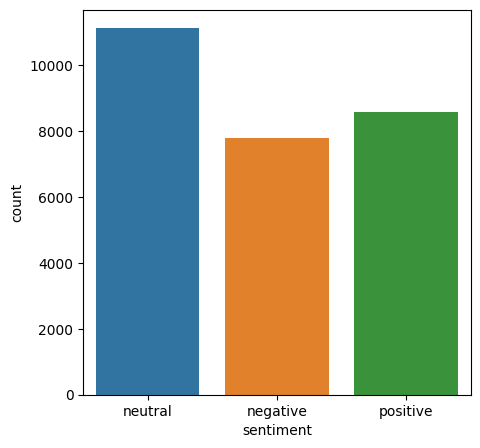

In [12]:
plt.figure(figsize=(5, 5))
sns.countplot(df_train,x='sentiment')

<Axes: xlabel='sentiment', ylabel='count'>

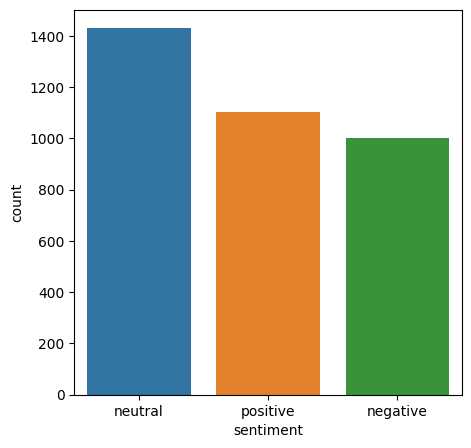

In [13]:
import seaborn as sns
plt.figure(figsize=(5, 5))
sns.countplot(df_test,x='sentiment')

In [14]:
df_train.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [15]:
df_train.drop(columns = ['textID', 'selected_text'], axis=1, inplace=True)
# df_test.drop(columns = ['textID', 'selected_text'], axis=1, inplace=True)

In [16]:
# in tweet people will mention or tag other, 
pattern_handle=r'@\w+'  # Only matched if @ followed by alphanumeric characters & underscore

# removing website, web url will not give information about sentiment or emotions
pattern_web =  r"(([\w]+:)?//)?(([\d\w]|%[a-fA-F\d]{2,2})+(:([\d\w]|%[a-fA-f\d]{2,2})+)?@)?([\d\w][-\d\w]{0,253}[\d\w]\.)+[\w]{2,4}(:[\d]+)?(/([-+_~.\d\w]|%[a-fA-f\d]{2,2})*)*(\?(&?([-+_~.\d\w]|%[a-fA-f\d]{2,2})=?)*)?(#([-+_~.\d\w]|%[a-fA-f\d]{2,2})*)?"

# removing email, email id will not give information about sentiment or emotions
pattern_email= r"(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*)@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"

# hastage in tweet, Ex: #LLM, #Love, #LLAMA
pattern_hash=r'#(\w+)'

# Removing some of the chars are repeated more than twice ex: oh my goddddddddddddd!, good, luckkkkkkkkkkkkk! 
pattern_repeat=r'([A-Za-z])\1{2,}'

# removing Contraction
# Removing Emoji


In [17]:
import re
import contractions
import emoji
import string

def clean_text(tweet):

    text_modified = re.sub(pattern_web,'',tweet)

    text_modified = re.sub(pattern_handle," ",text_modified)
    
    text_modified = re.sub(pattern_hash," \\1",text_modified)
    
    text_modified = re.sub(pattern_email,' ',text_modified)
    
    text_modified = emoji.demojize(text_modified)
    
    #Replacing ` with ' to be used in contraction
    pattern_apos = r'`'
    text_modified = re.sub(pattern_apos,"'",text_modified)

    #Removing contractions
    text_modified=contractions.fix(text_modified)

    #Normalising repeated characters
    text_modified=re.sub(pattern_repeat,r'\1',text_modified)
    
    #Removing numbers
    pattern_num=r'[0-9]'
    text_modified=re.sub(pattern_num," ",text_modified)
    
    #Removing punctuation
    pattern_punc="[" + re.escape(string.punctuation) + "]"
    
    text_modified=re.sub(pattern_punc," ",text_modified)
    
    #lowering characters
    text_modified=text_modified.lower()

    #Removing extra white space chars
    pattern_space=r'\s+'
    
    text_modified=re.sub(pattern_space," ",text_modified)
    
    return text_modified

In [18]:
# Remove NaN in the dataset
df_train.dropna(axis=0, inplace=True)
df_test.dropna(axis=0, inplace=True)
# df_validate.dropna(axis=0, inplace=True)

# Removing the empty string rows from Dataset
df_train = df_train[df_train['text'].str.strip() != ""]
df_test = df_test[df_test['text'].str.strip() != ""]
# df_validate = df_validate[df_validate['text'].str.strip() != ""]


df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_text)
# df_validate['cleaned_text'] = df_validate['text'].apply(clean_text)

In [19]:
# Dropping unwanted Column
df_train.drop(columns = ['text'], axis=1, inplace=True)
df_test.drop(columns = ['text'], axis=1, inplace=True)
# df_validate.drop(columns = ['text'], axis=1, inplace=True)

# Rename column
df_train.rename(columns = {'cleaned_text': 'text'}, inplace=True)
df_test.rename(columns = {'cleaned_text': 'text'}, inplace=True)
df_train.rename(columns = {'sentiment': 'label'}, inplace=True)
df_test.rename(columns = {'sentiment': 'label'}, inplace=True)
# df_validate.rename(columns = {'cleaned_text': 'text'}, inplace=True)


df_train['label'] = df_train['label'].map(label2id)
df_test['label'] = df_test['label'].map(label2id)

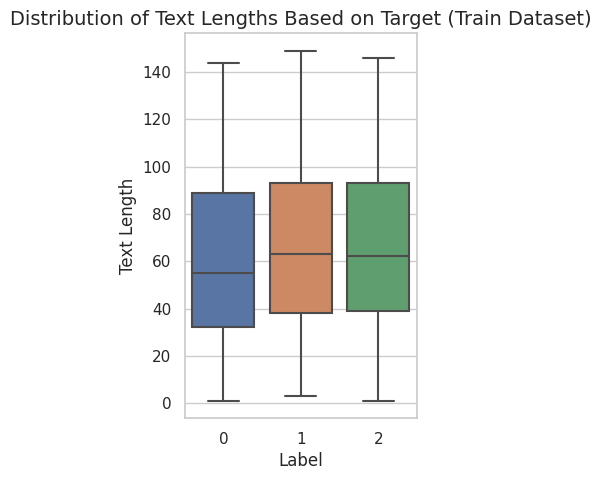

In [20]:
df = df_train.copy()
# Calculate the length of each string in the 'text' column
df['text_length'] = df['text'].apply(len)

# Set the style of the plot
sns.set(style="whitegrid")

# Visualize the length of strings based on the 'target' column using a boxplot
plt.figure(figsize=(3, 5))
sns.boxplot(x='label', y='text_length', data=df)

# Add title and labels
plt.title('Distribution of Text Lengths Based on Target (Train Dataset)', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Text Length', fontsize=12)

# Show the plot
plt.show()


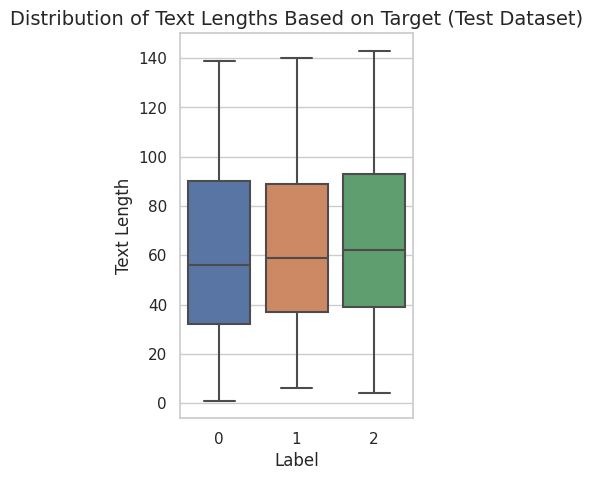

In [21]:
df = df_test.copy()
# Calculate the length of each string in the 'text' column
df['text_length'] = df['text'].apply(len)

# Set the style of the plot
sns.set(style="whitegrid")

# Visualize the length of strings based on the 'target' column using a boxplot
plt.figure(figsize=(3, 5))
sns.boxplot(x='label', y='text_length', data=df)

# Add title and labels
plt.title('Distribution of Text Lengths Based on Target (Test Dataset)', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Text Length', fontsize=12)

# Show the plot
plt.show()


In [22]:
# Convert Pandas DataFrames to Hugging Face Datasets
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "test": Dataset.from_pandas(df_test)
})

In [23]:
df_train.head(5)

,label,text
0,0,i would have responded if i were going
1,2,so sad i will miss you here in san diego
2,2,my boss is bullying me
3,2,what interview leave me alone
4,2,sons of why could not they put them on the re...


In [24]:
from collections import Counter

train_len, test_len = len(dataset['train']), len(dataset['test'])
# train_len, test_len = 7000, 1500

train_dataset_label_counts = Counter(dataset['train']['label'])
test_dataset_label_counts = Counter(dataset['test']['label'])

print(f"Train dataset: {train_len} samples, {train_dataset_label_counts}")
print(f"Test dataset: {test_len} samples, {test_dataset_label_counts}")

test_majority_class = test_dataset_label_counts.most_common(1)[0]

baseline_accuracy = test_majority_class[1] / test_len

print(f"Baseline accuracy: {baseline_accuracy:.2%}")

Train dataset: 27480 samples, Counter({0: 11117, 1: 8582, 2: 7781})
Test dataset: 3534 samples, Counter({0: 1430, 1: 1103, 2: 1001})
Baseline accuracy: 40.46%


In [25]:
import warnings
import os
from transformers import set_seed

SEED = 123
set_seed(SEED)

warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

INPUT_DIR = '/kaggle/input/nlp-getting-started/'

DIR = '/kaggle/working/'

NUM_WORKERS = os.cpu_count()

EPOCHS, R, LORA_ALPHA, LORA_DROPOUT = 3,16,32,0.1
BATCH_SIZE = 8

MODEL_ID = '/kaggle/input/llama-3.2/transformers/1b/1'
# MODEL_ID = "/kaggle/input/llama-3.1/transformers/8b/2"

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>3 |</span></b> <b>TOKENIZE THE TEXT DATA</b></div>

In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
print(tokenizer.padding_side, tokenizer.pad_token)
tokenizer.pad_token = tokenizer.eos_token
print(tokenizer.padding_side, tokenizer.pad_token)

right None
right <|end_of_text|>


In [27]:
tokenized_dataset = {}

for split in dataset.keys():
    tokenized_dataset[split] = dataset[split].map(
        lambda x: tokenizer(x["text"], truncation=True), batched=True
    )
    

tokenized_dataset["train"], tokenized_dataset["test"]

Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

(Dataset({
     features: ['label', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
     num_rows: 27480
 }),
 Dataset({
     features: ['textID', 'label', 'text', 'input_ids', 'attention_mask'],
     num_rows: 3534
 }))

In [28]:
NUM_CLASSES = len(set(dataset['train'].to_pandas()['label']))

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>4 |</span></b> <b>IMPORT PRETRAINED LLM MODAL (LLAMA 3.2 1B V1)</b></div>

In [29]:
from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(  
    load_in_8bit= True,
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=NUM_CLASSES,
    quantization_config = bnb_config
)
print(model.config.pad_token_id)
model.config.pad_token_id = model.config.eos_token_id
print(model.config.pad_token_id)


`low_cpu_mem_usage` was None, now set to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/llama-3.2/transformers/1b/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


None
128001


In [30]:
print(model)

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear8bitLt(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear8bitLt(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear8bitLt(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear8bitLt(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
     

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>5 |</span></b> <b>Performance Efficient Tunning (PEFT) using Quantized Low Rank Adaptation (QLoRA) </b></div>

In [31]:
from peft import prepare_model_for_int8_training

model = prepare_model_for_int8_training(model)

#model

In [32]:
from peft import LoraConfig, TaskType, get_peft_model

lora_config = LoraConfig(
    r=R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    task_type=TaskType.SEQ_CLS,
    target_modules='all-linear'
)
#lora_config

In [33]:
lora_model = get_peft_model(model, lora_config)
# lora_model

In [34]:
lora_model.print_trainable_parameters()

trainable params: 11,311,152 || all params: 1,247,164,512 || trainable%: 0.9069494754834717


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>6 |</span></b> <b>Train and Evaluation of LLM</b></div>

In [35]:
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}


In [36]:
trainer = Trainer(
    model=lora_model,
    args=TrainingArguments(
        output_dir="./data/",
        learning_rate=2e-5,  # Start with 2e-5, try other values in a range
        per_device_train_batch_size=16,  # Larger batch size if memory permits
        per_device_eval_batch_size=16,
        evaluation_strategy="epoch",  # You can change to "steps" if you want more frequent evals
        save_strategy="epoch",  # Save after every epoch
        save_total_limit=3,  # Limit the number of saved checkpoints to avoid excessive storage use
        num_train_epochs=EPOCHS,  # Adjust based on validation loss curve
        weight_decay=0.01,
        load_best_model_at_end=True,
        logging_steps=100,  # Log less frequently if training is long
        report_to="tensorboard",  # Useful for monitoring training progress
        fp16=False,  # Enable mixed-precision training (if hardware supports it)
        lr_scheduler_type="linear",  # Linear decay of learning rate
        dataloader_num_workers=4,  # Optimize data loading, adjust based on your CPU
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)


In [37]:
print("Evaluating the Model Before Training!")
trainer.evaluate()

Evaluating the Model Before Training!


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


{'eval_loss': 1.7894459962844849,
 'eval_model_preparation_time': 0.0044,
 'eval_accuracy': 0.3638936049801924,
 'eval_runtime': 60.5879,
 'eval_samples_per_second': 58.329,
 'eval_steps_per_second': 3.648}

In [38]:
print("Training the Model")
trainer.train()

Training the Model


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.548800,0.506178,0.004400,0.797397
2,0.444100,0.495509,0.004400,0.802773
3,0.419000,0.504934,0.004400,0.800792


TrainOutput(global_step=5154, training_loss=0.504505483873787, metrics={'train_runtime': 4180.062, 'train_samples_per_second': 19.722, 'train_steps_per_second': 1.233, 'total_flos': 1.395369816109056e+16, 'train_loss': 0.504505483873787, 'epoch': 3.0})

In [39]:
print("Evaluating the trained model")
trainer.evaluate()

Evaluating the trained model


{'eval_loss': 0.49456217885017395,
 'eval_model_preparation_time': 0.0044,
 'eval_accuracy': 0.801358234295416,
 'eval_runtime': 59.4341,
 'eval_samples_per_second': 59.461,
 'eval_steps_per_second': 3.718,
 'epoch': 3.0}

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>7 |</span></b> <b>Saving the Fine-Tuned Model for Future Use</b></div>

In [40]:
print("Saving the model!")
lora_model.save_pretrained('fine-tuned-model-sentiment-clf')
# tokenizer.save_pretrained('fine-tuned-model')

Saving the model!


In [41]:
from transformers import pipeline
import torch 

clf = pipeline("text-classification", lora_model, tokenizer=MODEL_ID)


The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification'

In [42]:
a = clf("Good morning")
print(a)
a[0]['label'].split("_")[1]

[{'label': 'LABEL_1', 'score': 0.9520286321640015}]


'1'

In [43]:
dataset_test = Dataset.from_pandas(df_test)

# Batch prediction function
def batch_predict(batch):
    try:
        predictions = clf(batch["text"])  # Apply classifier to batch of texts
    except:
        print(batch['text'])
        print(prediction)
        predictions = 0
    batch["prediction"] = [pred["label"].split("_")[1] for pred in predictions]  # Extract numeric labels
    return batch

# Apply the batch prediction function to the dataset
result_dataset = dataset_test.map(batch_predict, batched=True, batch_size=16)  # Adjust batch_size as needed

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [44]:
df_valid = result_dataset.to_pandas()

In [45]:
df_valid['prediction'] = df_valid['prediction'].astype(int)

Accuracy: 79.88%

Confusion Matrix:
[[1150  111  169]
 [ 193  891   19]
 [ 208   11  782]]


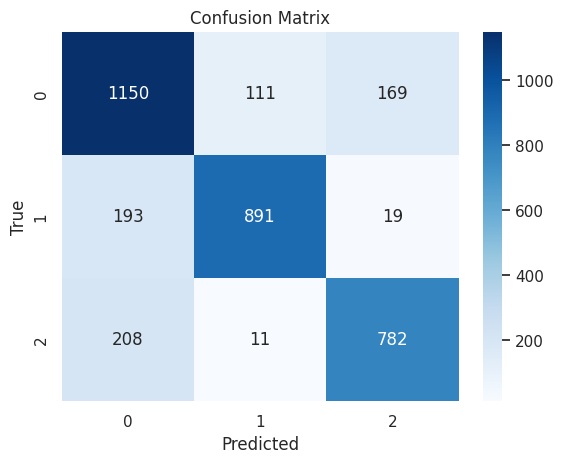


Classification Report:
              precision    recall  f1-score   support

     neutral       0.74      0.80      0.77      1430
    positive       0.88      0.81      0.84      1103
    negative       0.81      0.78      0.79      1001

    accuracy                           0.80      3534
   macro avg       0.81      0.80      0.80      3534
weighted avg       0.80      0.80      0.80      3534



In [46]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# 1. **Calculate Accuracy**
accuracy = accuracy_score(df_valid['label'], df_valid['prediction'])
print(f"Accuracy: {accuracy * 100:.2f}%")

# 2. **Confusion Matrix**
cm = confusion_matrix(df_valid['label'], df_valid['prediction'])
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix with a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 3. **Classification Report**
report = classification_report(df_valid['label'], df_valid['prediction'], target_names=['neutral', 'positive', 'negative'])
print("\nClassification Report:")
print(report)

In [47]:
df_valid

,textID,label,text,prediction
0,f87dea47db,0,last session of the day,0
1,96d74cb729,1,shanghai is also really exciting precisely sk...,1
2,eee518ae67,2,recession hit veronique branquinho she has to ...,2
3,01082688c6,1,happy birthday,1
4,33987a8ee5,1,i like it,1
...,...,...,...,...
3529,e5f0e6ef4b,2,its at am i am very tired but i cannot sleep b...,2
3530,416863ce47,1,all alone in this old house again thanks for t...,1
3531,6332da480c,2,i know what you mean my little dog is sinking...,2
3532,df1baec676,1,sutra what is your next youtube video going t...,1


In [48]:
import subprocess

# Retrieve token from environment variable
hf_token = secret_value_1

if hf_token:
    # Automate Hugging Face CLI login
    subprocess.run(
        ["huggingface-cli", "login", "--token", hf_token],
        check=True
    )
    print("Logged in to Hugging Face successfully!")
else:
    print("HF_TOKEN environment variable is not set.")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Logged in to Hugging Face successfully!


In [49]:
%pwd

'/kaggle/working'

In [50]:
print("Hi")

Hi


In [51]:
# Define the path of your file
file_path = './fine-tuned-model-sentiment-clf/README.md'

# Define the old and new values for 'base_model'
new_base_model_value= "/kaggle/input/llama-3.2/transformers/1b/1"
old_base_model_value= "meta/llama-3.2-1b"  # New value for base_model

# Open the file to read and replace the base_model value
with open(file_path, 'r') as file:
    content = file.read()

# Replace the old base_model value with the new one
content = content.replace(old_base_model_value, new_base_model_value)

# Write the updated content back to the file
with open(file_path, 'w') as file:
    file.write(content)

print(f"Base model path updated to: {new_base_model_value}")

Base model path updated to: /kaggle/input/llama-3.2/transformers/1b/1


In [52]:
"""from huggingface_hub import upload_folder

# Path to the local folder containing the model files
folder_path = "./fine-tuned-model-sentiment-clf"  # Local path

# Your Hugging Face repository ID
repo_id = "jayachandru001/sentiment_classification_using_llama_3.2_1B"  # Use your actual repo_id

# Upload the contents of the local folder to the Hugging Face repository
upload_folder(
    folder_path=folder_path,  # Local folder path containing your model
    repo_id=repo_id,  # Repo ID on Hugging Face
    path_in_repo=".",  # Root path in the repository
    commit_message="Uploading new fine-tuned model files"  # Optional commit message
)

print("Model files successfully pushed to Hugging Face!")
"""

'from huggingface_hub import upload_folder\n\n# Path to the local folder containing the model files\nfolder_path = "./fine-tuned-model-sentiment-clf"  # Local path\n\n# Your Hugging Face repository ID\nrepo_id = "jayachandru001/sentiment_classification_using_llama_3.2_1B"  # Use your actual repo_id\n\n# Upload the contents of the local folder to the Hugging Face repository\nupload_folder(\n    folder_path=folder_path,  # Local folder path containing your model\n    repo_id=repo_id,  # Repo ID on Hugging Face\n    path_in_repo=".",  # Root path in the repository\n    commit_message="Uploading new fine-tuned model files"  # Optional commit message\n)\n\nprint("Model files successfully pushed to Hugging Face!")\n'

In [53]:
# lora_model.push_to_hub(repo_name, use_auth_token=True, force=True)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb"><b><span style='color:#F1A424'>000 |</span></b> Load and Test the Uploaded Sentiment Classification model from Hugging Face<b></b></div>

In [54]:
!pip install -U peft==0.8.2

In [55]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig
from transformers import pipeline


SEN_NUM_CLASSES = 3

base_model_path = '/kaggle/input/llama-3.2/transformers/1b/1'
loaded_tokenizer = AutoTokenizer.from_pretrained(base_model_path)

loaded_base_model_sentiment = AutoModelForSequenceClassification.from_pretrained(base_model_path, num_labels=SEN_NUM_CLASSES,)

adapter_path2 = "jayachandru001/sentiment_classification_using_llama_3.2_1B_V2"

# Load the adapter configuration
# peft_config = PeftConfig.from_pretrained(adapter_path2)

# Attach the adapter to the base model
sentimentClf = PeftModel.from_pretrained(loaded_base_model_sentiment, adapter_path2)

# Verify the loaded model
# print(loaded_model)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/llama-3.2/transformers/1b/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

In [56]:
sentiment_clf = pipeline("text-classification", sentimentClf, tokenizer=loaded_tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassifi

In [57]:
sentiment_clf("I am not feeling well")

[{'label': 'LABEL_2', 'score': 0.996167004108429}]

<div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#1496bb">
  <b><span style='color:#F1A424'>🚀</span></b> 
  <b>Ready to Experience the AI Conversations?</b><br>
  🔮 <b>Click here to ask your own Empathetic AI Chatbot in the Cloud!</b> 🌐<br>
  💬 <b>Get personalized, compassionate responses in real-time with Gradio.</b> 🔥<br><br>
  <a href="https://huggingface.co/spaces/jayachandru001/Empathetic-AI-Bot" style="color:white;text-decoration:none;font-size:18px;font-weight:bold;background-color:#F1A424;padding:10px 20px;border-radius:5px;">Launch Your AI Bot Now!</a>
</div>
